# DNN applied to the IDS-2017

In this notebook, deep neural networks are used to create binary classifiers that distinguish between benign and malicious traffics in the ids-2017 dataset. Hyperparameters are optimized to obtain a model with the best results.

In [1]:
from notebook_utils import load_processed_dataset_2017, plot_confusion_matrix, metrics_report, upsample_dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score, make_scorer, precision_score, accuracy_score, confusion_matrix
%matplotlib inline
%load_ext autoreload
%autoreload 2
file_path = r"CIC-IDS-2017\CSVs\GeneratedLabelledFlows\TrafficLabelling\processed\ids2017_processed.csv"

In [2]:
X_train, Y_train, X_eval, Y_eval, X_test, Y_test, scaler = load_processed_dataset_2017(file_path)

In [3]:
performance_models = {}

## 1. Prototype

Epoch 1/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 662us/step - accuracy: 0.9375 - loss: 0.1556 - val_accuracy: 0.2645 - val_loss: 4.8462
Epoch 2/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 660us/step - accuracy: 0.9534 - loss: 0.1105 - val_accuracy: 0.3350 - val_loss: 6.1369
Epoch 3/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 665us/step - accuracy: 0.9545 - loss: 0.1196 - val_accuracy: 0.3341 - val_loss: 7.5082
Epoch 4/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 660us/step - accuracy: 0.9554 - loss: 0.1084 - val_accuracy: 0.2976 - val_loss: 5.6531
Epoch 5/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 65s 665us/step - accuracy: 0.9560 - loss: 0.1074 - val_accuracy: 0.3386 - val_loss: 8.3944
Epoch 6/50
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 64s 660us/step - accuracy: 0.9565 - loss: 0.1157 - val_accuracy: 0.3320 - val_loss: 7.5057
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 4s 421us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9795    0.9765    0.9780    227310


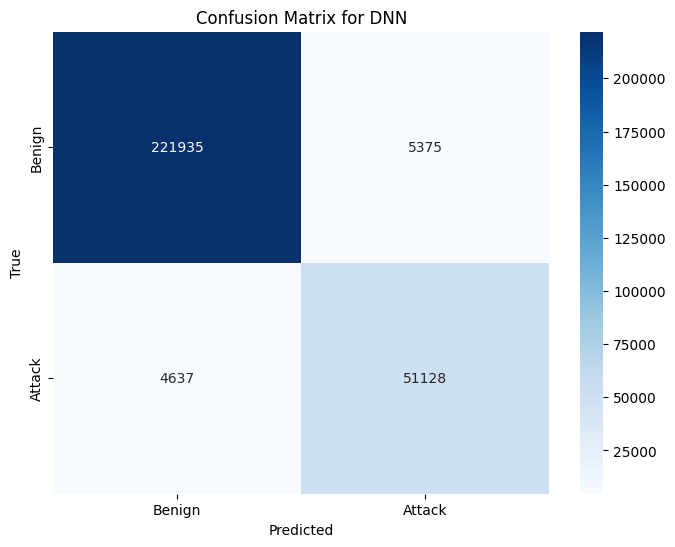

In [4]:
# Define the model architecture
model = Sequential([
    keras.layers.Input(shape=(scaler.transform(X_train).shape[1],)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(scaler.transform(X_train), Y_train.is_attack, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predict probabilities on the evaluation set
y_pred_eval_prob = model.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 2. Hyperparameter Tuning

In this section, a random grid search is perform in an attempt to find a satisfying model. Previously, these hyperparameters were found to perform best.
{'units_input': 480, 'num_layers': 2, 'units_0': 448, 'dropout_0': 0.30000000000000004, 'learning_rate': 0.00614260757976685, 'units_1': 224, 'dropout_1': 0.0, 'units_2': 256, 'dropout_2': 0.4}

In [5]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
from keras_tuner import RandomSearch

directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning')
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection'
)

tuner.search_space_summary()

# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

Reloading Tuner from G:\Other computers\My PC\stage\ML-NIDS\Notebooks\hyperparam_tuning\intrusion_detection\tuner0.json
Search space summary
Default search space size: 9
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step'

In [7]:
# Build the model with the best hyperparameters
model1 = build_model(best_hps)

# Train the model
history = model1.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

# Save the best model
def save_keras_model(model, model_name):
    file_path = f'models/{model_name}.keras'
    model.save(file_path)
    print(f'Model saved to {file_path}')

save_keras_model(model1, 'DNN_model1')

C:\Users\youss\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 181s 2ms/step - accuracy: 0.9390 - loss: 0.1689 - val_accuracy: 0.2715 - val_loss: 8.9465
Epoch 2/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 178s 2ms/step - accuracy: 0.9384 - loss: 0.5678 - val_accuracy: 0.2495 - val_loss: 17.2619
Epoch 3/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 174s 2ms/step - accuracy: 0.9416 - loss: 0.3142 - val_accuracy: 0.7567 - val_loss: 19.8276
Epoch 4/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 187s 2ms/step - accuracy: 0.9370 - loss: 0.4160 - val_accuracy: 0.2729 - val_loss: 62.7580
Epoch 5/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 174s 2ms/step - accuracy: 0.9353 - loss: 0.3636 - val_accuracy: 0.5448 - val_loss: 9.0004
Epoch 6/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 190s 2ms/step - accuracy: 0.9239 - loss: 0.3753 - val_accuracy: 0.2200 - val_loss: 12.2143
Epoch 7/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 185s 2ms/step - accuracy: 0.9245 - loss: 0.3506 - val_accuracy: 0.5771 - val_loss: 26.3872
Epoch 8/20
97279/97279 ━━━━━━━━━━━━━━━━━━━━ 170s 2ms/step

8847/8847 ━━━━━━━━━━━━━━━━━━━━ 5s 616us/step
Classification Report (Evaluation):
              precision    recall  f1-score   support

           0     0.9473    0.9838    0.9652    227310
           1     0.9216    0.7768    0.8430     55764

    accuracy                         0.9430    283074
   macro avg     0.9344    0.8803    0.9041    283074
weighted avg     0.9422    0.9430    0.9411    283074

Accuracy: 0.9430149006973442
8847/8847 ━━━━━━━━━━━━━━━━━━━━ 5s 617us/step
Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9478    0.9837    0.9654    227310
           1     0.9215    0.7790    0.8443     55765

    accuracy                         0.9434    283075
   macro avg     0.9346    0.8814    0.9049    283075
weighted avg     0.9426    0.9434    0.9416    283075

Accuracy: 0.9433966263357767


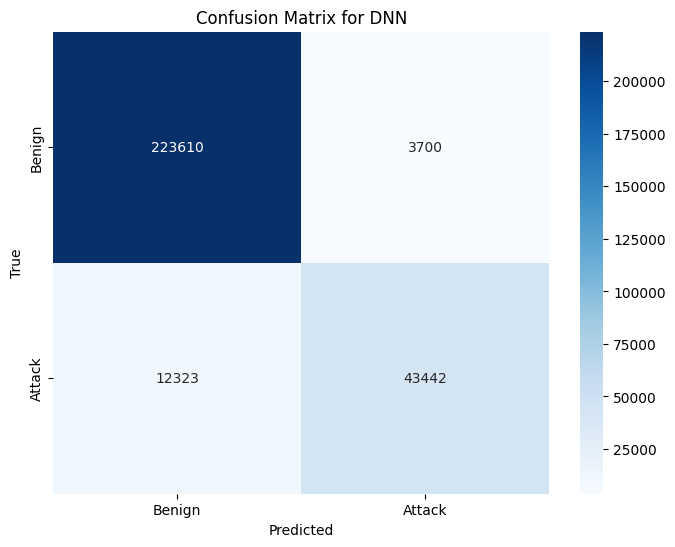

In [8]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model1.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model1.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN1"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 3. Hyperparameter tuning with Hypermodel

In [9]:
from tensorflow.keras import layers
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        
        model.add(layers.Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1)))
        
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

In [10]:
directory_path = os.path.join(os.getcwd(), 'hyperparam_tuning_hypermodel')
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory=directory_path,
    project_name='intrusion_detection_hypermodel'
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_input (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
# Perform the search
tuner.search(scaler.transform(X_train), Y_train.is_attack, epochs=10, validation_split=0.2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |units_input
0.4               |0.4               |dropout_input
2                 |2                 |num_layers
64                |64                |units_0
0.1               |0.1               |dropout_0
0.00049998        |0.00049998        |learning_rate


Epoch 1/10
21296/97279 ━━━━━━━━━━━━━━━━━━━━ 47s 625us/step - accuracy: 0.9202 - loss: 0.1893

In [ ]:
# Build the model with the best hyperparameters
hypermodel = MyHyperModel()
model2 = hypermodel.build(best_hps)

# Train the model
history = model2.fit(scaler.transform(X_train), Y_train.is_attack, epochs=20, validation_split=0.2, verbose=1)

save_keras_model(model2, 'DNN_model2')

In [ ]:
# Predict probabilities on the evaluation set
y_pred_eval_prob = model2.predict(scaler.transform(X_eval))
# Convert probabilities to binary predictions
y_pred_eval = (y_pred_eval_prob > 0.5).astype(int)
metrics_report("Evaluation", Y_eval.is_attack, y_pred_eval, print_avg=False)

# Predict and evaluate on the test set
y_pred_test_prob = model2.predict(scaler.transform(X_test))
y_pred_test = (y_pred_test_prob > 0.5).astype(int)
performance_models["DNN2"] = metrics_report("Test", Y_test.is_attack, y_pred_test, print_avg=False)
plot_confusion_matrix("DNN", Y_test, y_pred_test)

## 4. Conclusion

In [ ]:
extract_and_plot_metrics(performance_models)